In [0]:
# Import the pandas library to read our dataset
import pandas as pd

# Get the train/test split package from sklearn for preparing our dataset to
# train and test the model with
from sklearn.model_selection import train_test_split

# Import the numpy library to work with and manipulate the data
import numpy as np

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep='\t')

In [5]:
# Check the head of the dataframe
data.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [6]:
# check the shape of df
data.shape

(156060, 4)

In [0]:
numSentences = data['SentenceId'].max()

In [0]:
# extract full sentences only from the dataset
fullSentences = []
curSentence = 0
for i in range(data.shape[0]):
  if data['SentenceId'][i]> curSentence:
    fullSentences.append((data['Phrase'][i], data['Sentiment'][i]))
    curSentence = curSentence +1

In [9]:
len(fullSentences)

8544

In [0]:
# put data into a df
fullSentDf = pd.DataFrame(fullSentences,
                                columns=['Phrase', 'Sentiment'])

In [11]:
data['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [12]:
# Check class imbalance in full sentences
fullSentDf['Sentiment'].value_counts()

3    2325
1    2203
2    1659
4    1282
0    1075
Name: Sentiment, dtype: int64

In [13]:
import nltk
import random
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
documents = []

# Use only complete sentences
for i in range(fullSentDf.shape[0]):
  tmpWords = word_tokenize(fullSentDf['Phrase'][i])
  documents.append((tmpWords, fullSentDf['Sentiment'][i]))

In [15]:
random.seed(9001)
random.shuffle(documents)
print(documents[1][0])

['For', 'its', '100', 'minutes', 'running', 'time', ',', 'you', "'ll", 'wait', 'in', 'vain', 'for', 'a', 'movie', 'to', 'happen', '.']


In [16]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

#parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = False
useLemma = True
removePuncs = True

for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue
    if useStemming:
      #newWord = porter.stem(newWord)
      newWord = lancaster.stem(newWord)
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (' '.join(tmpReview), label)
print(documents[2])

('Ian Holm conquers France earthy Napoleon', 3)


In [0]:
all_data = pd.DataFrame(documents,
                                columns=['text', 'sentiment'])
# Splits the dataset so 70% is used for training and 30% for testing
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(all_data['text'], all_data['sentiment'], test_size=0.3)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                           ngram_range=(1, 1))
#vectorizer = CountVectorizer(stop_words="english" , ngram_range=(1, 1))
x_train = vectorizer.fit_transform(x_train_raw)
y_train = y_train_raw
x_test = vectorizer.transform(x_test_raw)
y_test = y_test_raw

In [0]:
# Converts the datasets to numpy arrays to work with our Keras model
x_train_np = x_train.toarray()
y_train_np = np.array(y_train)

# Convert the testing data
x_test_np = x_test.toarray()
y_test_np = np.array(y_test)

In [20]:
#x_train_np = np.reshape(x_train_np, (x_train_np.shape[2],x_train_np.shape[1],x_train_np.shape[0]))
print(x_train_np.shape)
print(y_train_np.shape)

(5980, 11702)
(5980,)


In [21]:
# Converting 2-D to 3-D 
x_train_np = np.expand_dims(x_train_np, 2)
x_test_np = np.expand_dims(x_test_np, 2)
print(x_train_np.shape)

(5980, 11702, 1)


In [22]:

from keras.utils import to_categorical
y_train_np = to_categorical(y_train_np)
y_test_np = to_categorical(y_test_np)
print(y_train_np.shape)



Using TensorFlow backend.


(5980, 5)


In [0]:
# define the function for recall,precision,figure-of metric score
from keras import backend as K
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision= precision_m(y_true, y_pred)
  recall= recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# import the neccesary libraries for the training the model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.layers import Activation, Conv1D, GlobalMaxPooling1D
from keras import optimizers
from keras import layers

In [0]:
# define convolution neural network
def cnn_model(data, num_class, opt):
  model= Sequential()
  model.add(Conv1D(filters=32, kernel_size=2, activation= 'relu', input_shape= (data.shape[1],data.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=64, kernel_size=2, activation= 'relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=128, kernel_size=2, activation= 'relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Activation('relu'))
  model.add(Dense(num_class))
  model.add(Activation('softmax'))
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
  
  return model

In [26]:
# assign values to variables
batch_size= 64
num_epochs= 10
n_class = 5
Nadam = optimizers.Nadam(lr = 1e-3 , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# SGD = optimizers.SGD(lr=1e-5)
# compile the model
model=cnn_model(x_train_np, n_class, Nadam)

In [27]:
# run the model
x = model.fit(x_train_np, y_train_np, batch_size=batch_size, epochs=10, verbose=1,validation_data=(x_test_np,y_test_np))
# save model with 10 epoch
model.save('1116576_1dconv_reg.h5') 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5980 samples, validate on 2564 samples
Epoch 1/10





5980/5980 [==============================] - 17s 3ms/step - loss: 1.5201 - acc: 0.3211 - f1_m: 0.0272 - precision_m: 0.2374 - recall_m: 0.0147 - val_loss: 1.4674 - val_acc: 0.3354 - val_f1_m: 0.0500 - val_precision_m: 0.5393 - val_recall_m: 0.0265
Epoch 2/10
5980/5980 [==============================] - 4s 613us/step - loss: 1.1571 - acc: 0.5229 - f1_m: 0.4163 - precision_m: 0.6469 - recall_m: 0.3134 - val_loss: 1.5879 - val_acc: 0.3284 - val_f1_m: 0.2357 - val_precision_m: 0.3650 - val_recall_m: 0.1751
Epoch 3/10
5980/5980 [==============================] - 4s 622us/step - loss: 0.8751 - acc: 0.6677 - f1_m: 0.6322 - precision_m: 0.7486 - recall_m: 0.5493 - val_loss: 1.7911 - val_acc: 0.3261 - val_f1_m: 0.2727 - val_precision_m: 0.3494 - val_recall_m: 0.2243
Epoch 4/10
5980/5980 [==============================] - 4s 616us/step -

In [28]:
def metrics(accuracy,f1_score,precision,recall):
  print('CNN model performance')
  print('Accuracy:', np.round(accuracy,2))
  print('Precision: ', np.round(precision,2))
  print("recall:", np.round(recall,2))
  print("f1score:", np.round(f1_score,2))
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test_np, y_test_np, verbose=False)
metrics(accuracy,f1_score,precision,recall)

CNN model performance
Accuracy: 0.32
Precision:  0.32
recall: 0.31
f1score: 0.32


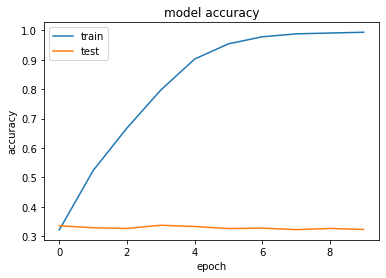

In [29]:
import matplotlib.pyplot as plt
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plothist(x)